In [1]:
import numpy as np
import rerun as rr
import laspy
import os
import open3d as o3d
import matplotlib.pyplot as plt
from collections import Counter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
input_file = os.path.join('..', 'data', 'pcd_wilhelmina_park', 'whm_250x250.LAZ')

# Thinning options
thinning_factor = 1.0  # Set the percentage to keep (1.0 means keep everything)

# Open and read the LAS file
with laspy.open(input_file, laz_backend=laspy.LazBackend.Laszip) as f:
    original_las = f.read()

    # Optionally thin the point cloud
    if 0 < thinning_factor < 1.0:
        print(f"Thinning the point cloud with factor {thinning_factor}...")
        # Downsample the point cloud by step
        step = int(1 / thinning_factor)  # Calculate the step size
        thinned_points = original_las.points[::step]  # Select every nth point
        print(f"Original points: {len(original_las.points)}, Thinned points: {len(thinned_points)}")
        original_las.points = thinned_points
    else:
        print("Thinning not applied. Keeping all points.")

    print("\nPoint Attributes:")
    # Set column width
    col_width = 25  # Adjust this value for better spacing

    # Loop through dimensions
    for dimension in f.header.point_format.dimension_names:
        dtype = original_las[dimension].dtype
        min_val = original_las[dimension].min()
        max_val = original_las[dimension].max()
        print(f"{dimension.ljust(col_width)} {str(dtype).ljust(col_width)} "
              f"Min: {str(min_val).ljust(col_width)} Max: {str(max_val).ljust(col_width)}")


Thinning not applied. Keeping all points.

Point Attributes:
X                         int32                     Min: 431000                    Max: 681000                   
Y                         int32                     Min: 987000                    Max: 1237000                  
Z                         int32                     Min: -1418                     Max: 35317                    
intensity                 uint16                    Min: 266                       Max: 65535                    
return_number             uint8                     Min: 1                         Max: 11                       
number_of_returns         uint8                     Min: 1                         Max: 11                       
synthetic                 uint8                     Min: 0                         Max: 0                        
key_point                 uint8                     Min: 0                         Max: 0                        
withheld                  u

In [3]:
# Normalize color bands
bit8 = 255
bit16 = 65535

nir_raw = np.array(original_las.nir, dtype=np.float64) / bit8 #original_las.nir.max()
red_raw = np.array(original_las.red, dtype=np.float64) / bit8 #original_las.red.max()
green_raw = np.array(original_las.green, dtype=np.float64) / bit8 #original_las.green.max()
blue_raw = np.array(original_las.blue, dtype=np.float64) / bit8 #original_las.blue.max()

# nir_raw = np.array(original_las.nir, dtype=np.float64) / bit8
# red_raw = np.array(original_las.red, dtype=np.float64) / bit16
# green_raw = np.array(original_las.green, dtype=np.float64) / bit16
# blue_raw = np.array(original_las.blue, dtype=np.float64) / bit16    

In [4]:
#function to get the ndvi values
def get_ndvi(red, nir):
    red = np.array(red, dtype=np.float64)
    nir = np.array(nir, dtype=np.float64)
    
    return (nir - red) / (nir+ red + 1e-8)


In [5]:
#calculate ndvi and add it to the las attributes
#overwrite potentially existing ndvi

if 'ndvi' not in original_las.point_format.dimension_names:
    original_las.add_extra_dim(laspy.ExtraBytesParams(name='ndvi', type=np.float32))

# Assign the NDVI values
original_las.ndvi = get_ndvi(red_raw, nir_raw)
ndvi_raw = original_las.ndvi

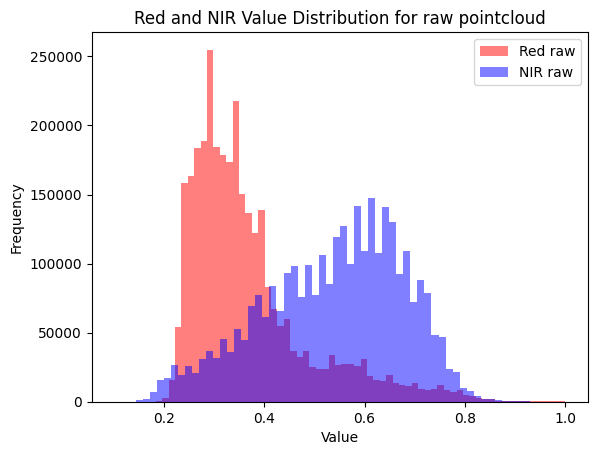

red values: max = 1.0	min = 0.1843137254901961
nir values: max = 1.0	min = 0.10196078431372549


In [6]:
#debugging for NDVI values being between -.4 and .4 instead of -1 and 1
plt.hist(red_raw, bins=64, alpha=0.5, label='Red raw', color='red')
plt.hist(nir_raw, bins=64, alpha=0.5, label='NIR raw', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Red and NIR Value Distribution for raw pointcloud')
plt.legend()
plt.show()

print(f'red values: max = {red_raw.max()}\tmin = {red_raw.min()}')
print(f'nir values: max = {nir_raw.max()}\tmin = {nir_raw.min()}')

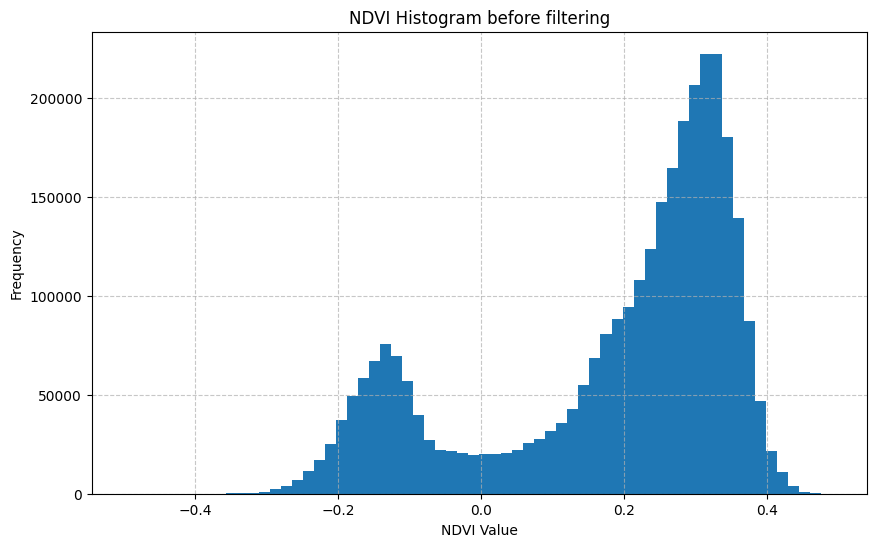

 min ndvi value: -0.4954954981803894
 max ndvi value: 0.4910714328289032


In [7]:
def plot_ndvi_histogram(ndvi_values, name='<No Name>'):
    """Plot a histogram of NDVI values."""
    plt.figure(figsize=(10, 6))
    plt.hist(ndvi_values, bins=64)#, linewidth=.5, edgecolor='black')
    plt.title(f"NDVI Histogram {name}")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

    print(f' min ndvi value: {min(ndvi_values)}')
    print(f' max ndvi value: {max(ndvi_values)}')

plot_ndvi_histogram(original_las.ndvi, 'before filtering')


In [8]:
# Mapping AHN classification codes to their meanings
AHN_classification_mapping = {
    0: "Created, never classified",
    1: "Unclassified",
    2: "Ground",
    6: "Building",
    9: "Water",
    14: "High tension",
    26: "Civil structure"
}

# Extract classification values from the LAS file
classification_values = original_las.classification

# Print unique classification values and their meanings
unique_values = np.unique(classification_values)
print("Unique Classification Values and Meanings:")
for value in unique_values:
    meaning = AHN_classification_mapping.get(value, "Unknown")  # Handle unknown classifications
    print(f"Class {value}:\t{meaning}")

# Count the occurrences of each classification
counts = Counter(classification_values)

# Sort the classifications by count in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Display the classification counts in a tabular format
print("\nClassification Counts (Ordered by Frequency):")

# Define column widths for alignment
class_col_width = 10  
meaning_col_width = 25  
count_col_width = 15  

# Print header
print(f"{'Class'.ljust(class_col_width)} {'Meaning'.ljust(meaning_col_width)} {'Points'.rjust(count_col_width)}")
print("-" * (class_col_width + meaning_col_width + count_col_width + 5))

# Print the counts for each classification
for cls, count in sorted_counts:
    meaning = AHN_classification_mapping.get(cls, "Unknown")
    print(f"{str(cls).ljust(class_col_width)} {meaning.ljust(meaning_col_width)} {str(count).rjust(count_col_width)}")


Unique Classification Values and Meanings:
Class 1:	Unclassified
Class 2:	Ground
Class 6:	Building
Class 9:	Water
Class 26:	Civil structure

Classification Counts (Ordered by Frequency):
Class      Meaning                            Points
-------------------------------------------------------
1          Unclassified                      1713767
2          Ground                            1193124
6          Building                           220532
26         Civil structure                     11333
9          Water                                 203


## Below the filtering of the pointcloud takes place

In [21]:
#create copy of las_original to perform filtering on the copy (called las for simplicity)
las = laspy.LasData(original_las.header)
las.points = original_las.points.copy()

#Filter to keep only Unclassified points
# las = las[las.classification == 1]

#Filter out points with NDVI value under threshold
ndvi_threshold = 0.0
las = las[las.ndvi > ndvi_threshold]


#Remove points with single return
# las = las[las.number_of_returns > 1]

#Remove last return of all remaining points
# las = las[las.return_number != las.number_of_returns]


In [22]:
# Remove outliers using SOR
def remove_outliers(las_data, nb_neighbors=20, std_ratio=2.0):
    # Convert LAS data to Open3D point cloud
    xyz = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    # Perform statistical outlier removal
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    
    # Filter the original LAS data
    filtered_las = las_data[ind]
    
    return filtered_las

# After your previous filtering steps:
las = remove_outliers(las, 20, 2.0)

In [23]:
def normalize_array(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [24]:
# Save bands in numpy arrays for furhter use
nir_new = np.array(las.nir, dtype=np.float64) / bit8 # las.nir.max()
red_new = np.array(las.red, dtype=np.float64) / bit8 #las.red.max()
green_new = np.array(las.green, dtype=np.float64) / bit8 #las.green.max()
blue_new = np.array(las.blue, dtype=np.float64) / bit8 #las.blue.max()

ndvi_new = np.array(las.ndvi, dtype=np.float64)

print(f'nir values:\tmin = {nir_new.min()}\tmax = {nir_new.max()}')
print(f'red values:\tmin = {red_new.min()}\tmax = {red_new.max()}')
print(f'green values:\tmin = {green_new.min()}\tmax = {green_new.max()}')
print(f'blue values:\tmin = {blue_new.min()}\tmax = {blue_new.max()}')
print(f'ndvi values:\tmin = {ndvi_new.min()}\tmax = {ndvi_new.max()}')

nir values:	min = 0.21176470588235294	max = 1.0
red values:	min = 0.1843137254901961	max = 0.984313725490196
green values:	min = 0.2823529411764706	max = 1.0
blue values:	min = 0.21176470588235294	max = 0.9803921568627451
ndvi values:	min = 0.0022271715570241213	max = 0.4910714328289032


In [25]:
def visualize_pcd_ndvi_nir_red(las_data):
    # Initialize rerun
    rr.init("NDVI, NIR, Red", spawn=True)

    # Disable labels before running your visualization
    rr.config.set_option("view_labels", False)
    
    # Get point coordinates for the two pointclouds
    points = np.column_stack((las_data.x, las_data.y, las_data.z))

    #calculate ndvi values
    ndvi_values = get_ndvi(las_data.red, las_data.nir)
    
    # Normalize NIR and Red values to 0-1 range     BTW this is max FOUND values not max possible
    red_norm = normalize_array(las_data.red)
    nir_norm = normalize_array(las_data.nir)
    

    # Create color array: Red channel for Red values, Green for NDVI, Blue for NIR
    colors = np.column_stack(((ndvi_values + 1) / 2, # NDVI is already in [-1, 1] range, normalize to [0, 1]
                              red_norm,
                              nir_norm
                            ))

    # Log the point cloud to rerun
    rr.log("point_cloud", rr.Points3D(positions=points,
                                        colors=colors,
                                        radii=.5,  # Adjust point size as needed
                                        labels=[f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}" 
                                                for ndvi, nir, red in zip(ndvi_values, las_data.nir, las_data.red)]))

    # Log some text to provide context
    rr.log("info", rr.TextLog("Point cloud: Red channel = Red band, Green channel = NDVI, Blue channel = NIR band. Hover for values."))

    print(f"Visualization ready. Run 'rerun' in terminal to view.")

In [28]:
def labels_list(las):
    # return [f"NDVI: {ndvi:.3f}, NIR: {nir:.3f}, Red: {red:.3f}, Green: {green:.3f}, Blue: {blue:.3f}"
    #         for ndvi, nir, red, green, blue in zip(las.ndvi, las.nir, las.red, las.green, las.blue)]
    return [f"NDVI: {ndvi:.3f}, return: {return_i}/{num_of_ret}, class: {classif}"
            for ndvi, return_i, num_of_ret, classif in zip(las.ndvi, las.return_number, las.number_of_returns, las.classification)]
    


def visualize_pcd_filtered_vs_original(las_filtered, las_original):
    # Initialize rerun
    rr.init("Filtered AND Original", spawn=True)
    
    # Get point coordinates for the two pointclouds
    points_original = np.column_stack((las_original.x, las_original.y, las_original.z))
    points_filtered = np.column_stack((las_filtered.x, las_filtered.y, las_filtered.z))

    # Make original pointcloud white
    # colors_original = np.ones((len(points_original), 3))

    # make original pointcloud original RGB values
    
    colors_original = np.column_stack((normalize_array(las_original.red), 
                                       normalize_array(las_original.green),
                                       normalize_array(las_original.blue)))

    #add alpha to original points
    # alpha_value = 0.5
    # colors_original = np.column_stack((colors_original, np.full(colors_original.shape[0], alpha_value)))


    # Make filtered pointcloud green
    colors_filtered = np.column_stack(( np.zeros(len(points_filtered)),
                                        np.ones(len(points_filtered)),
                                        np.zeros(len(points_filtered))))

    # Log the original point cloud
    rr.log("original_point_cloud", rr.Points3D( positions=points_original,
                                                colors=colors_original,
                                                radii=.1,
                                                labels= labels_list(las_original)))

    # Log the filtered point cloud
    rr.log("filtered_point_cloud", rr.Points3D( positions=points_filtered,
                                                colors=colors_filtered,
                                                radii=.2, #slightly larger than original for visualization 
                                                labels=labels_list(las_filtered))) 

    print(f"Visualization ready. Run 'rerun' in terminal to view.")


Visualization ready. Run 'rerun' in terminal to view.


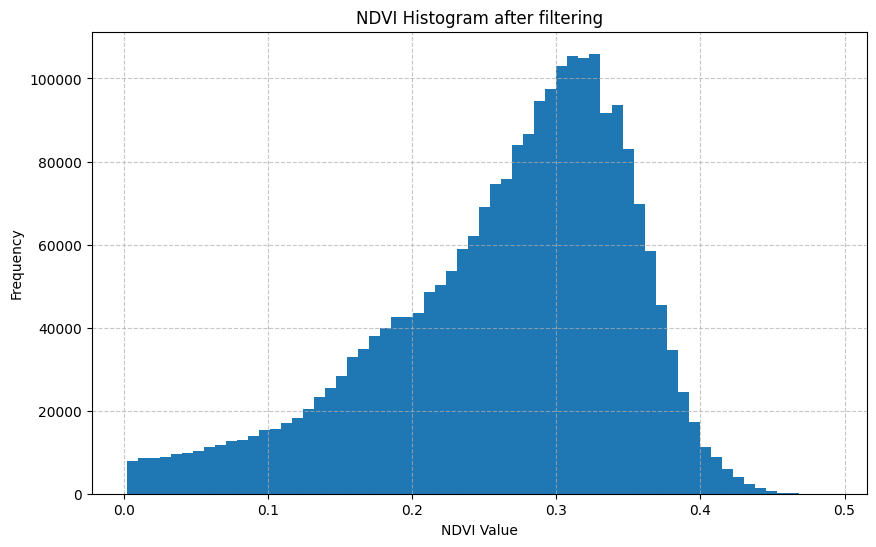

 min ndvi value: 0.0022271715570241213
 max ndvi value: 0.4910714328289032


In [29]:
# visualize_pcd_ndvi_nir_red(las)
visualize_pcd_filtered_vs_original(las, original_las)



plot_ndvi_histogram(las.ndvi, name='after filtering')

# Continue with Open3D to calculate and output alpha shape

In [16]:
# Load points
points = np.vstack((las.x, las.y, las.z)).transpose()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optional: Downsample the point cloud if it's too large
# voxel_size = 0.05  # Adjust this value as needed
# pcd = pcd.voxel_down_sample(voxel_size)

In [17]:
# Cluster the point cloud using DBSCAN
eps = 1.5  # Adjust this value based on your data
min_points = 10  # Minimum number of points to form a cluster
labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))

# Get the number of clusters (excluding noise, which is labeled as -1)
max_label = labels.max()
print(f"Number of clusters: {max_label + 1}")


Number of clusters: 213


In [18]:
# DEBUG: Visualize a specific cluster (e.g., cluster 0)
cluster_points = pcd.select_by_index(np.where(labels == 500)[0])
o3d.visualization.draw_geometries([cluster_points])

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
